## Object

$$ J = \sum_{i, j=1}^{V}f(X_{ij})(Wi^{T}  Wj + b_{j} + b_{i} - log(X_{ij}))^{2} $$

In [21]:
from __future__ import division
from collections import defaultdict, Counter


import os
import tensorflow as tf
from random import shuffle
import jieba

In [304]:
corpus = """
我喜欢吃苹果，也喜欢跑步。
我喜欢吃香蕉，也喜欢散步。
他喜欢吃苹果，也喜欢跑步。
他喜欢吃香蕉，也喜欢散步。
"""

In [305]:
class NotFitToCorpusError(Exception):
    pass

In [306]:
class Glove(object):
    def __init__(self, window_size,max_vocab_size,min_cooccurrence, embedding_size, 
                 coocurrence_max=100, alpha=0.75, batch_size=10, learning_rate=0.1):
        if type(window_size) == tuple:
            self.left_size, self.right_size = window_size
        else:
            self.left_size = self.right_size = window_size
        
        self.max_vocab_size = max_vocab_size
        self.min_cooccurrence = min_cooccurrence
        self.embedding_size = embedding_size
        self.coocurrence_max = coocurrence_max
        self.alpha = alpha
        self.batch_size = batch_size
        self.__embedding = None
        self.__cooccurrence_matrix = None
        self.learning_rate = learning_rate
        
    def _window(self, region, start, end):
        '''
        return list of words from start index to end index of region
        '''
        last_index = len(region) + 1
        return region[max(0, start): min(end, last_index) + 1]
    
    def _context_window(self, region):
        for i, word in enumerate(region):
            start = i - self.left_size
            end = i + self.right_size
            left_context = self._window(region, start, i-1)
            right_context = self._window(region, i+1, end)
            yield (left_context, word, right_context)
    
    def fit_corpus(self, corpus):
        self._fit_corpus(corpus, self.max_vocab_size, self.min_cooccurrence)
        self.build_model()
    
    def _fit_corpus(self, corpus, vocab_size, min_count):
        words = Counter()
        coocurrence_counts = defaultdict(float)
        for region in corpus:
            words.update(region)
            for left_context, word, right_context in self._context_window(region):
                # add 1 / distance to word pair
                for i, c in enumerate(left_context[::-1]):
                    coocurrence_counts[(word, c)] += 1 / (i + 1)
                for i, c in enumerate(right_context):
                    coocurrence_counts[(word, c)] += 1 / (i + 1)
        
        self.__words = [word for word, count in words.most_common(vocab_size) if count >= min_count]
        self.__word_2_id = {w: _id for _id, w in enumerate(self.__words)}
        self.__cooccurrence_matrix = {(self.__word_2_id[word_pair[0]], self.__word_2_id[word_pair[1]]): count
                                     for word_pair, count in coocurrence_counts.items()
                                     if word_pair[0] in self.__words and word_pair[1] in self.__words}
        
        
    def build_model(self):
        self.__graph = tf.Graph()
        with self.__graph.as_default():
            count_max = tf.constant([self.coocurrence_max], dtype=tf.float32, name='coocurrence_max')
            alpha = tf.constant([self.alpha], dtype=tf.float32, name='alpha')

            self.__focus_input = tf.placeholder(tf.int32, shape=[self.batch_size], name='focus_words')
            self.__context_input = tf.placeholder(tf.int32, shape=[self.batch_size], name='context_words')
            self.__cooccurrance_count = tf.placeholder(tf.float32, shape=[self.batch_size], name='cooccurrance_count')

            focus_embeddings = tf.Variable(tf.random_uniform([self.vocab_size, self.embedding_size], 1.0, -1.0, name='focus_embeddings'))
            context_embeddings = tf.Variable(tf.random_uniform([self.vocab_size, self.embedding_size], 1.0, -1.0, name='context_embeddings'))
            focus_bias = tf.Variable(tf.random_uniform([self.vocab_size], 1.0, -1.0, name='focus_bias'))
            context_bias = tf.Variable(tf.random_uniform([self.vocab_size], 1.0, -1.0, name='context_bias'))

            focus_emb = tf.nn.embedding_lookup([focus_embeddings], self.__focus_input)
            context_emb = tf.nn.embedding_lookup([context_embeddings], self.__context_input)
            focus_b = tf.nn.embedding_lookup([focus_bias], self.__focus_input)
            context_b = tf.nn.embedding_lookup([context_bias], self.__context_input)

            weighting_factor = tf.minimum(1.0, tf.pow(tf.div(self.__cooccurrance_count, count_max), alpha))

            embedding_product = tf.reduce_sum(tf.multiply(focus_emb, context_emb), 1)
            log_cooccurrence = tf.log(tf.to_float(self.__cooccurrance_count))

            distance_exp = tf.square(tf.add_n([embedding_product, focus_b, context_b, tf.negative(log_cooccurrence)]))
            loss_one = tf.multiply(weighting_factor, distance_exp)

            self.__total_loss = tf.reduce_sum(loss_one)
#             tf.summary.scalar('glove_loss', self.__total_loss)
            print(self.__total_loss)
            self.__optimizer = tf.train.AdagradOptimizer(self.learning_rate).minimize(self.__total_loss)
#             tf.summary = tf.summary.merge_all()
            self.combine_embedding = tf.add(focus_embeddings, context_embeddings, name='combine_embedding')

    def train(self, epochs):
        batches = self.__prepare_batches()
        total_step = 0
        
        with tf.Session(graph=self.__graph) as sess:
            tf.global_variables_initializer().run()
            
            for epoch in range(epochs):
                shuffle(batches)
                for batch_data in batches:
                    i_indexs, j_indexs, counts = batch_data
                    if len(counts) != self.batch_size:
                        continue
                    
                    feed_dict = {
                        self.__focus_input: i_indexs,
                        self.__context_input: j_indexs,
                        self.__cooccurrance_count: counts
                    }
                    sess.run([self.__optimizer, self.__total_loss], feed_dict=feed_dict)
                    total_step += 1
                
            self.__embedding = self.combine_embedding.eval()
     
    @property
    def words(self):
        if self.__words is None:
            raise NotFitToCorpusError('need to fit copus before start model')
        return self.__words
    
    @property
    def vocab_size(self):
        return len(self.words)
    
    @property
    def embeddings(self):
        if self.__embedding is None:
            raise NotFitToCorpusError('not fit')
        
        return self.__embedding
    
    def generate_tsne(self, path=None, size=(100, 100), word_count=1000, embeddings=None):
        if embeddings is None:
            embeddings = self.embeddings
        from sklearn.manifold import TSNE
        tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
        low_dim_embs = tsne.fit_transform(embeddings[:word_count, :])
        labels = self.words[:word_count]
        return _plot_with_labels(low_dim_embs, labels, path, size)
    
    def __prepare_batches(self):
        if self.__cooccurrence_matrix is None:
            raise NotFitToCorpusError(
                "Need to fit model to corpus before preparing training batches.")
        cooccurrences = [(word_ids[0], word_ids[1], count)
                         for word_ids, count in self.__cooccurrence_matrix.items()]
        i_indices, j_indices, counts = zip(*cooccurrences)
        return list(_batchify(self.batch_size, i_indices, j_indices, counts))
    
def _batchify(batch_size, *sequences):
    for i in range(0, len(sequences[0]), batch_size):
        yield tuple(sequence[i:i+batch_size] for sequence in sequences)

    
    


In [307]:
#显示中文
import matplotlib as mlt

# [f.name for f in mlt.font_manager.fontManager.ttflist]

In [308]:
def _plot_with_labels(low_dim_embs, labels, path, size):
    import matplotlib.pyplot as plt
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    figure = plt.figure(figsize=size)  # in inches
    
    plt.rcParams['font.sans-serif'] = ['STFangsong']
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right',
                     va='bottom')
    if path is not None:
        figure.savefig(path)
        plt.close(figure)

In [309]:
corpus_list = corpus.split()

In [310]:
def split_words(cor):
    stop_words = [',', '.', '，', '。', ':', '：', '/', '；']
    cut_c = list(jieba.cut(cor))
    return [c for c in cut_c if c not in stop_words]

In [311]:
token = [split_words(cor) for cor in corpus_list]

In [312]:
glove = Glove(window_size=5,max_vocab_size=100, min_cooccurrence = 1, embedding_size=10)

In [313]:
glove.fit_corpus(token)

Tensor("Sum_1:0", shape=(), dtype=float32)


In [314]:
glove.words

['喜欢', '吃', '也', '我', '苹果', '跑步', '香蕉', '散步', '他']

In [315]:
glove.train(100)

In [316]:
glove.embeddings

array([[ 0.52527547, -0.75928116,  0.61695457, -0.22688322,  0.56773937,
         0.7498862 ,  0.9985434 , -0.754923  ,  0.3575942 , -0.6042925 ],
       [ 0.22061568, -1.4303073 , -0.5390147 ,  0.03642514, -1.2750477 ,
         0.45894784,  2.1594446 , -0.10673267,  1.2786946 ,  0.25862646],
       [ 0.14628899, -0.5754013 ,  0.7087447 ,  0.5578232 , -1.4579823 ,
         0.37938982, -0.43644118, -0.6563008 ,  0.865909  , -0.42368427],
       [-1.4785494 , -1.0902619 , -0.35460117,  0.18694541,  0.67853826,
         0.8275889 ,  0.99403435, -0.7602881 , -1.194007  ,  0.49118927],
       [ 0.67107975, -1.2055147 ,  1.2255635 ,  0.04910412, -1.0699718 ,
        -1.9251139 ,  1.8923182 ,  0.5020014 ,  0.25295788, -0.74998266],
       [-0.899381  ,  1.3956175 ,  0.9632489 , -0.8570343 ,  0.10158437,
        -0.941746  , -0.33938962, -0.833922  ,  1.2539747 ,  0.9579678 ],
       [-0.51349235,  0.274795  , -0.3832942 ,  0.49712586,  0.10508215,
         0.32138395,  0.13877425,  0.36840427

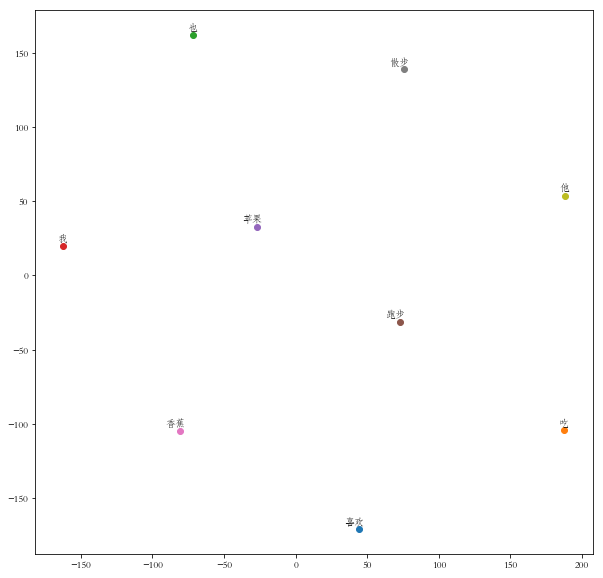

In [317]:
%matplotlib inline
glove.generate_tsne(size=(10,10))